# Getting Started with TensorFlow!

This notebook shows how to get started with Quantus with `tensorflow`. For this purpose, we use a pretrained EfficientNet model and a subset of ImageNet dataset.

Install dependencies.

In [ ]:
!pip install quantus tensorflow tf-explain tesorflow_datasets matplotlib

If running locally on OSX, install [Metal Device Plugin](https://developer.apple.com/metal/tensorflow-plugin/), which will allow tensorflow to execute computations on GPU.

In [ ]:
!pip install tensorflow_metal

Import dependencies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import quantus

tf.config.list_physical_devices()

2022-10-22 23:04:26.075837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1) Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [3]:
IMG_SIZE = 224

# Load dataset
ds = tfds.load(
    'imagenet_v2',
    data_dir='/tmp/tensorflow_datasets',
    split=['test'],
    as_supervised=True,
    try_gcs=True,
    batch_size=8,
)

x_batch, y_batch = ds[0].take(1).as_numpy_iterator().next()
x_batch = tf.image.resize(x_batch, (IMG_SIZE, IMG_SIZE)).numpy()
x_batch.shape

(8, 224, 224, 3)

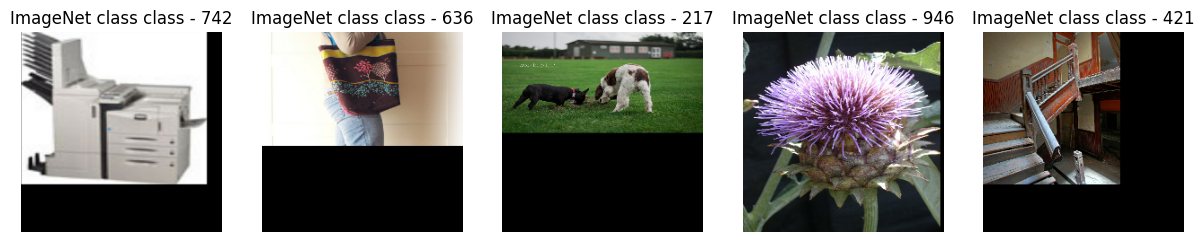

In [4]:
# Plot some inputs!
nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images * 3, int(nr_images * 2 / 3)))
for i, (x, y) in enumerate(zip(x_batch[:nr_images], y_batch[:nr_images])):
    axes[i].imshow(x.astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"ImageNet class class - {y}")
    axes[i].axis("off")

### 1.2 Load pre-trained model

In [5]:
model = tf.keras.applications.EfficientNetB0()
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `tf-explain`.

In [6]:
# Generate Integrated Gradients attributions of the first batch of the test set.
y_predicted = model.predict(x_batch).argmax(axis=1)
a_batch_intgrad = quantus.explain(model, x_batch, y_predicted, method='IntegratedGradients')
a_batch_intgrad.shape

1/1 [==============================] - 9s 9s/step


(8, 224, 224)

Visualise attributions given model and pairs of input-output.

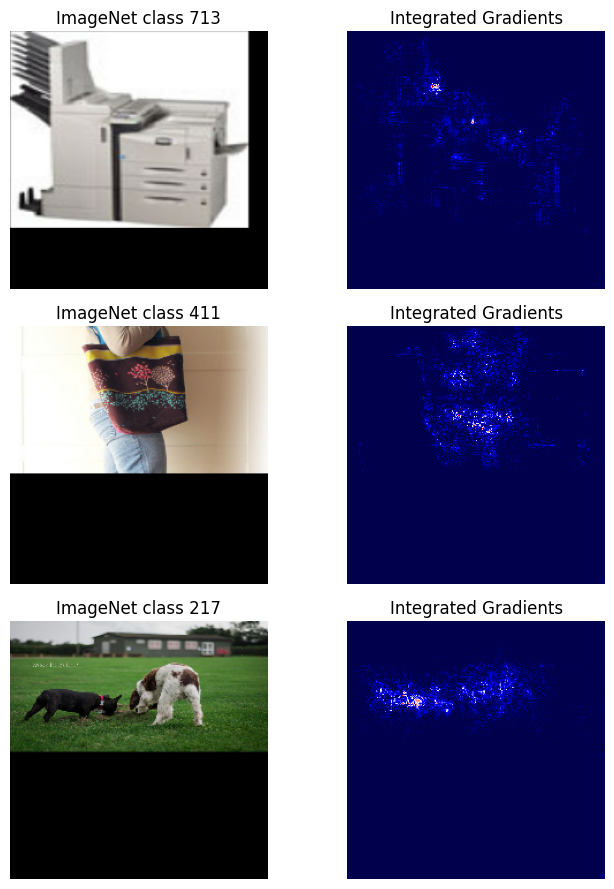

In [7]:
# Plot explanations!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images * 2.5, int(nr_images * 3)))
for i, (x, y, a) in enumerate(zip(x_batch[:nr_images], y_predicted[:nr_images], a_batch_intgrad[:nr_images])):
    axes[i, 0].imshow(x.astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i, 0].title.set_text(f"ImageNet class {y}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(a, cmap="seismic")
    axes[i, 1].title.set_text(f"Integrated Gradients")
    axes[i, 1].axis("off")
plt.tight_layout()

## 2) Quantative evaluation using Quantus
In this part, few of the metrics available in quantus are demonstrated.

### [Max Sensitivity](https://arxiv.org/abs/2005.00631)
This metric tests how the explanations maximally change while subject to slight perturbations.

In [37]:
# We will use mostly the same parameters for all metrics
sensitivity_init_kwargs = {
    "nr_samples": 10,
    "perturb_func": quantus.functions.perturb_func.random_noise,
    "upper_bound": 10,
    "disable_warnings": True,
    "abs": True,
    "display_progressbar": True
}
sensitivity_call_kwargs = {
    "model": model,
    "x_batch": x_batch,
    "y_batch": y_batch,
    "explain_func": quantus.explain,
    "explain_func_kwargs": {"method": "IntegratedGradients"}
}

In [38]:
# Define metric for evaluation.
max_sen = quantus.MaxSensitivity(**sensitivity_init_kwargs)
# Return Max Sensitivity scores for Integrated Gradients.
score_max_sen = max_sen(**sensitivity_call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/helpers/warn.py:262: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


### [Average Sensitivity](https://arxiv.org/abs/2005.00631)
This metric tests how the explanations change on average while subject to slight perturbations.

In [39]:
# Define metric for evaluation.
avg_sen = quantus.AvgSensitivity(**sensitivity_init_kwargs)
# Return Average Sensitivity scores for Integrated Gradients.
score_avg_sen = avg_sen(**sensitivity_call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

### [Relative Stability](https://arxiv.org/abs/2203.06877)
RS leverages the changes in explanations, as a subject to change in
input -> relative input stability
output logits -> relative output stability
internal representations -> relative representation stability

In [40]:
# We will use mostly the same parameters for all metrics
rs_init_kwargs = {
    "nr_samples": 10,
    "perturb_func": quantus.functions.perturb_func.random_noise,
    "perturb_func_kwargs": {"upper_bound": 10},
    "disable_warnings": True,
    "abs": True,
    "display_progressbar": True
}
rs_call_kwargs = {
    "model": model,
    "x_batch": x_batch,
    "y_batch": y_batch,
    "explain_func": quantus.explain,
    "explain_func_kwargs": {"method": "IntegratedGradients"}
}

In [50]:
# Instantiate metric
ris = quantus.RelativeInputStability(**rs_init_kwargs)
# Run evaluation
ris_result = ris(**rs_call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
# Instantiate metric
ros = quantus.RelativeOutputStability(**rs_init_kwargs)
# Run evaluation
ros_result = ris(**rs_call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

The authors of the RS paper didn't provide any code examples. Neither did they specify which internal representations to take into account.
We expect RRS to be sensitive to this choice.

User can provide either `layer_names` or `layer_indices` as kwargs, to select, which layers outputs should be taken into account.
Providing neither will force usage of all.

In [43]:
# Instantiate metric
rrs_1 = quantus.RelativeRepresentationStability(**rs_init_kwargs)
# Run evaluation
rrs_result_1 = rrs_1(**rs_call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/helpers/model/tf_model.py:167: UserWarning: quantus.TensorFlowModel.get_hidden_layers_representations(...) received `layer_names`=None and `layer_indices`=None. This will force creation of tensorflow.keras.Model with outputs of each layer from original model. This can be very computationally expensive.
  warn(


In [44]:
# Instantiate metric
rrs_2 = quantus.RelativeRepresentationStability(**rs_init_kwargs, layer_names=('top_conv'))
# Run evaluation
rrs_result_2 = rrs_2(**rs_call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
# Instantiate metric
rrs_3 = quantus.RelativeRepresentationStability(**rs_init_kwargs, layer_indices=(1, 2, 3))
# Run evaluation
rrs_result_3 = rrs_3(**rs_call_kwargs)

  0%|          | 0/1 [00:00<?, ?it/s]

Now, we display all results in tabular form.

In [49]:
all_results = np.asarray([
    score_avg_sen,
    score_max_sen,
    ris_result,
    ros_result,
    rrs_result_1,
    rrs_result_2,
    rrs_result_3
])
all_results.shape

/var/folders/vv/f22t8y7d1l96ynv9mzgy0j5w0000gn/T/ipykernel_59177/3059267827.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_results = np.asarray([


KeyboardInterrupt: 

In [ ]:
print(f"max-Sensitivity scores by Yeh et al., 2019\n" \
      f"\n • Gradient = {np.mean(scores_grad):.2f} ({np.std(scores_grad):.2f})." \
      f"\n • Integrated Gradients = {np.mean(scores_intgrad):.2f} ({np.std(scores_intgrad):.2f})."
      )

max-Sensitivity scores by Yeh et al., 2019

 • Gradient = 1.25 (0.31).
 • Integrated Gradients = 1.15 (0.31).
